## Importing Stuff

In [5]:
from comet_ml import start
from comet_ml.integration.pytorch import log_model
from comet_ml.integration.pytorch import watch
import comet_ml


In [6]:
import torch
import torch.nn as nn
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import PIL
import torch.optim as optim
import torch
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [7]:
## Checking the CUDA
if torch.cuda.is_available():
    print("CUDA is available!")
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available!
Current GPU: NVIDIA GeForce RTX 4060 Laptop GPU


## Loading The Data

In [4]:

data_dir = '/root/data/Data/images_original'


train_transforms = transforms.Compose([
    transforms.Resize((180,180)),
    transforms.ToTensor(),
])



full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)

train_size = int(0.7 * len(full_dataset))  # 70% for training
val_size = int(0.15 * len(full_dataset))   # 15% for validation
test_size = len(full_dataset) - train_size - val_size  # Remaining 15% for testing


train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


for images, labels in train_loader:
    print(images.shape, labels)
    break

torch.Size([32, 3, 180, 180]) tensor([7, 9, 6, 3, 2, 7, 1, 1, 1, 4, 2, 8, 9, 8, 4, 3, 1, 7, 3, 9, 9, 3, 3, 4,
        2, 6, 0, 0, 6, 6, 9, 1])


## Metrics Function

In [8]:

def plot_metrics(train_losses, val_losses, test_loss=0, train_accuracies=0, val_accuracies=0, test_accuracy=0, gan=False):
    epochs = range(1, len(train_losses) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    if gan==False :
        # Plot Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracies, label='Train Accuracy')
        plt.plot(epochs, val_accuracies, label='Val Accuracy')
        plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()

## Train Function

In [7]:
def train (model,experiment,hyper,optimizer,loss_fn=nn.CrossEntropyLoss()) :
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = [] 
    for epoch in range(hyper['epochs']):
        model.cuda()
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_accuracy = 0.0

        # Training loop
        for imgs, labels in train_loader:
            imgs = imgs.cuda()
            labels = labels.cuda()

            # Forward pass
            output = model(imgs)
            loss = loss_fn(output, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update running loss and accuracy
            running_loss = 0.99 * running_loss + 0.01 * loss.item()
            preds = torch.argmax(output, dim=1)
            running_accuracy = 0.99 * running_accuracy + 0.01 * accuracy_score(labels.cpu(), preds.cpu())

        # Store training loss and accuracy
        train_losses.append(running_loss)
        train_accuracies.append(running_accuracy)
        experiment.log_metric ("train_loss", running_loss)
        experiment.log_metric ("train_accuracy", running_accuracy)
        # Print training loss and accuracy
        print(f"Epoch {epoch+1}/{hyper['epochs']}")
        print(f"Train Loss: {running_loss:.4f}, Train Accuracy: {running_accuracy:.4f}")

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_accuracy = 0.0
        with torch.no_grad():  # Disable gradient computation
            for imgs, labels in val_loader:
                imgs = imgs.cuda()
                labels = labels.cuda()

                output = model(imgs)
                loss = loss_fn(output, labels)

                val_loss += loss.item()
                preds = torch.argmax(output, dim=1)
                val_accuracy += accuracy_score(labels.cpu(), preds.cpu())

        # Average validation loss and accuracy
        val_loss /= len(val_loader)
        val_accuracy /= len(val_loader)

        # Store validation loss and accuracy
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        experiment.log_metric ("val_loss", val_loss)
        experiment.log_metric ("val_accuracy", val_accuracy)
        # Print validation loss and accuracy
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Testing loop (optional, can be done after training)
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.cuda()
            labels = labels.cuda()

            # Forward pass
            output = model(imgs)
            loss = loss_fn(output, labels)

            # Update test loss and accuracy
            test_loss += loss.item()
            preds = torch.argmax(output, dim=1)
            test_accuracy += accuracy_score(labels.cpu(), preds.cpu())

    # Average test loss and accuracy
    test_loss /= len(test_loader)
    test_accuracy /= len(test_loader)
    experiment.log_metric ("test_loss", test_loss)
    experiment.log_metric ("test_accuracy", test_accuracy)
    # Print test loss and accuracy
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies, test_loss, test_accuracy

## FCN Model

In [5]:
input_size=180*180*3
hidden_size1=64
hidden_size2=32
output_size=10

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.layer1=nn.Linear(input_size,hidden_size1)
    self.layer2=nn.Linear(hidden_size1,hidden_size2)
    self.layer3=nn.Linear(hidden_size2,output_size)
    self.relu=nn.ReLU()
  def forward(self,x):
    x=x.flatten(start_dim=1)
    #print (x.size())
    x=self.layer1(x)
    x=self.relu(x)
    x=self.layer2(x)
    x=self.relu(x)
    x=self.layer3(x)

    return x

In [ ]:
experiment_fcn = comet_ml.start(
  api_key="dEZzsaQExxOoLg04pynbidvNw",
  project_name="Deep Learning Technologies",
  workspace="gibranfil"
)

experiment_fcn.set_name ("FCN")
hyper_param_fcn = {'learning_rate' : 0.01, 'epochs' : 50}
experiment_fcn.log_parameters (hyper_param_fcn)
model_fcn = Net()
running_loss=0.0
optimizer_fcn=optim.SGD(model_fcn.parameters(),lr=hyper_param_fcn['learning_rate'])


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/gibranfil/deep-learning-technologies/46aebebcebc849469b4da21edec64801



In [ ]:
log_model(experiment_fcn, model=model_fcn, model_name="FCN")
train_loss, val_loss, train_acc, val_acc, test_loss, test_acc= train (model_fcn, experiment_fcn, hyper_param_fcn,optimizer_fcn) 
    

Epoch 1/50
Train Loss: 0.4591, Train Accuracy: 0.0202
Val Loss: 2.2988, Val Accuracy: 0.1318
Epoch 2/50
Train Loss: 0.4564, Train Accuracy: 0.0217
Val Loss: 2.3224, Val Accuracy: 0.0720
Epoch 3/50
Train Loss: 0.4580, Train Accuracy: 0.0190
Val Loss: 2.3035, Val Accuracy: 0.0503
Epoch 4/50
Train Loss: 0.4568, Train Accuracy: 0.0206
Val Loss: 2.2986, Val Accuracy: 0.0753
Epoch 5/50
Train Loss: 0.4542, Train Accuracy: 0.0236
Val Loss: 2.2733, Val Accuracy: 0.2071
Epoch 6/50
Train Loss: 0.4522, Train Accuracy: 0.0326
Val Loss: 2.2778, Val Accuracy: 0.1095
Epoch 7/50
Train Loss: 0.4457, Train Accuracy: 0.0322
Val Loss: 2.2323, Val Accuracy: 0.1848
Epoch 8/50
Train Loss: 0.4423, Train Accuracy: 0.0353
Val Loss: 2.2016, Val Accuracy: 0.1848
Epoch 9/50
Train Loss: 0.4382, Train Accuracy: 0.0350
Val Loss: 2.2046, Val Accuracy: 0.1378
Epoch 10/50
Train Loss: 0.4299, Train Accuracy: 0.0350
Val Loss: 2.1520, Val Accuracy: 0.1565
Epoch 11/50
Train Loss: 0.4284, Train Accuracy: 0.0383
Val Loss: 2.18

In [9]:
experiment_fcn.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : FCN
COMET INFO:     url                   : https://www.comet.com/gibranfil/deep-learning-technologies/46aebebcebc849469b4da21edec64801
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [110]          : (1.5625747442245483, 2.412865161895752)
COMET INFO:     test_accuracy       : 0.27853260869565216
COMET INFO:     test_loss           : 1.9143215417861938
COMET INFO:     train_accuracy [50] : (0.019045915087045874, 0.060133566382171294)
COMET INFO:     train_loss [50]     : (0.37179086931756805, 0.4591354497152865)
COMET INFO:     val_accuracy [50]   : (0.05029761904761905, 0.3449404761904762)
COMET INFO:     val_loss [50]       : (1.853

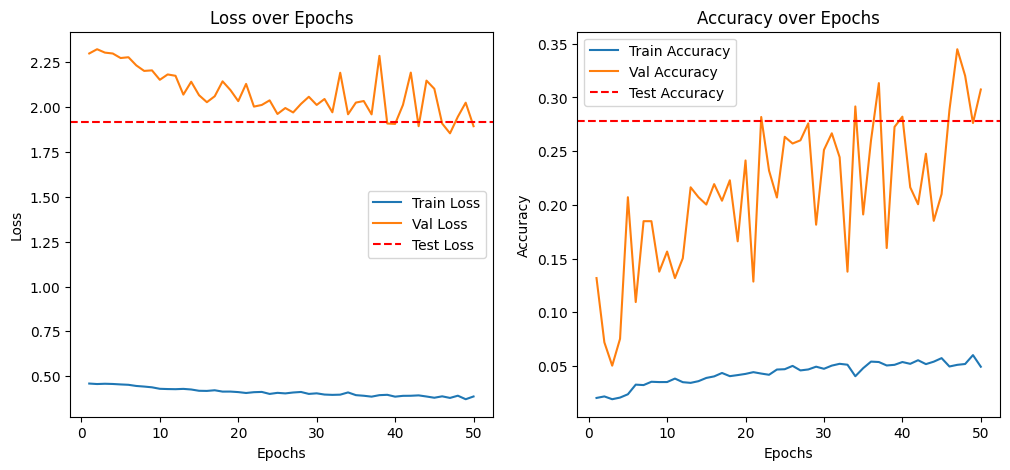

In [ ]:
plot_metrics(train_loss, val_loss,test_loss, train_acc, val_acc, test_acc)

## CNN Model

In [8]:
class CNNet(nn.Module):
  def __init__(self,batch = False):
    super(CNNet, self).__init__()
    self.layer1=nn.Conv2d(3,128,kernel_size=2)
    self.batch1 = nn.BatchNorm2d(128)
    self.layer2=nn.Conv2d(128,64,kernel_size=2)
    self.batch2 = nn.BatchNorm2d(64)
    self.layer3=nn.Conv2d(64,32,kernel_size=2)
    self.batch3 = nn.BatchNorm2d(32)
    self.layer4=nn.Conv2d(32,16,kernel_size=2)
    self.batch4 = nn.BatchNorm2d(16)
    self.pooling = nn.MaxPool2d (kernel_size=(2, 2))
    self.lin1 = nn.Linear (16 * 43 * 43, 128,128)
    self.lin2 = nn.Linear (128,10)
    self.relu=nn.ReLU()
    self.batch_check = batch
    
  def forward(self, x):
      # Define layers and whether pooling should be applied after them
      layers = [
          (self.layer1, self.batch1, False),  # (layer, batch_norm, pooling_bool)
          (self.layer2, self.batch2, True),
          (self.layer3, self.batch3, False),
          (self.layer4, self.batch4, True)
      ]

      for layer, batch_norm, apply_pooling in layers:
          x = layer(x)
          if self.batch_check:
              x = batch_norm(x)
          x = self.relu(x)
          if apply_pooling:
              x = self.pooling(x)

  
      x = x.flatten(start_dim=1)
      x = self.lin1(x)
      x = self.relu(x)
      x = self.lin2(x)

      return x

In [12]:
experiment_cnn = comet_ml.start(
  api_key="dEZzsaQExxOoLg04pynbidvNw",
  project_name="Deep Learning Technologies",
  workspace="gibranfil"
)
experiment_cnn.set_name ("cnn")


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/gibranfil/deep-learning-technologies/1717813513aa4ae786216ed621e21462



In [14]:
hyper_param_cnn = {'learning_rate' : 0.01, 'epochs' : 50}
experiment_cnn.log_parameters (hyper_param_cnn)
lr=0.01
epochs=50
model_cnn = CNNet()
loss_fn=nn.CrossEntropyLoss()
optimizer_cnn=optim.SGD(model_cnn.parameters(),lr=hyper_param_cnn['learning_rate'])
running_loss=0.0

In [15]:

log_model(experiment_cnn, model=model_cnn, model_name="CNN")
train_loss, val_loss, train_acc, val_acc, test_loss, test_acc= train (model_cnn, experiment_cnn,hyper_param_cnn,optimizer_cnn) 

Epoch 1/50
Train Loss: 0.4573, Train Accuracy: 0.0178
Val Loss: 2.3014, Val Accuracy: 0.0875
Epoch 2/50
Train Loss: 0.4570, Train Accuracy: 0.0205
Val Loss: 2.3030, Val Accuracy: 0.0875
Epoch 3/50
Train Loss: 0.4568, Train Accuracy: 0.0205
Val Loss: 2.3041, Val Accuracy: 0.1062
Epoch 4/50
Train Loss: 0.4567, Train Accuracy: 0.0190
Val Loss: 2.3048, Val Accuracy: 0.1003
Epoch 5/50
Train Loss: 0.4566, Train Accuracy: 0.0193
Val Loss: 2.3056, Val Accuracy: 0.1003
Epoch 6/50
Train Loss: 0.4566, Train Accuracy: 0.0212
Val Loss: 2.3058, Val Accuracy: 0.1003
Epoch 7/50
Train Loss: 0.4564, Train Accuracy: 0.0213
Val Loss: 2.3063, Val Accuracy: 0.1003
Epoch 8/50
Train Loss: 0.4564, Train Accuracy: 0.0214
Val Loss: 2.3059, Val Accuracy: 0.1003
Epoch 9/50
Train Loss: 0.4564, Train Accuracy: 0.0213
Val Loss: 2.3056, Val Accuracy: 0.1003
Epoch 10/50
Train Loss: 0.4563, Train Accuracy: 0.0230
Val Loss: 2.3053, Val Accuracy: 0.1003
Epoch 11/50
Train Loss: 0.4561, Train Accuracy: 0.0301
Val Loss: 2.30

In [16]:
experiment_cnn.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : cnn
COMET INFO:     url                   : https://www.comet.com/gibranfil/deep-learning-technologies/1717813513aa4ae786216ed621e21462
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [110]          : (1.6168025732040405, 2.430388927459717)
COMET INFO:     test_accuracy       : 0.3432065217391304
COMET INFO:     test_loss           : 1.7960276365280152
COMET INFO:     train_accuracy [50] : (0.01776251484707767, 0.07085959754866214)
COMET INFO:     train_loss [50]     : (0.35456150468537206, 0.45727148123822564)
COMET INFO:     val_accuracy [50]   : (0.0875, 0.3794642857142857)
COMET INFO:     val_loss [50]       : (1.7779508352279663, 

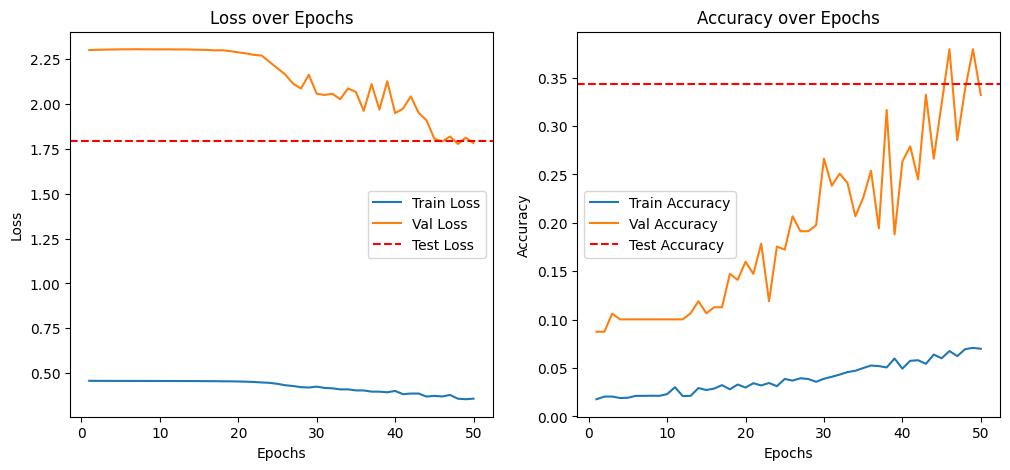

In [17]:
plot_metrics(train_loss, val_loss,test_loss, train_acc, val_acc, test_acc)

In [9]:
experiment_cnn_batch = comet_ml.start(
  api_key="dEZzsaQExxOoLg04pynbidvNw",
  project_name="Deep Learning Technologies",
  workspace="gibranfil"
)
experiment_cnn_batch.set_name ("cnn")


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/gibranfil/deep-learning-technologies/9ae99a53985d44f499130e9cdbdc4f25



In [10]:
hyper_param_cnn_batch = {'learning_rate' : 0.01, 'epochs' : 50}
experiment_cnn_batch.log_parameters (hyper_param_cnn_batch)

model_cnn_batch = CNNet(batch=True)
loss_fn=nn.CrossEntropyLoss()
optimizer_cnn=optim.SGD(model_cnn_batch.parameters(),lr=hyper_param_cnn_batch['learning_rate'])
running_loss=0.0

In [11]:
log_model(experiment_cnn_batch, model=model_cnn_batch, model_name="CNN Batch")
train_loss, val_loss, train_acc, val_acc, test_loss, test_acc= train (model_cnn_batch, experiment_cnn_batch,hyper_param_cnn_batch,optimizer_cnn) 

Epoch 1/50
Train Loss: 0.4532, Train Accuracy: 0.0327
Val Loss: 2.2437, Val Accuracy: 0.1568
Epoch 2/50
Train Loss: 0.3872, Train Accuracy: 0.0540
Val Loss: 2.0068, Val Accuracy: 0.2318
Epoch 3/50
Train Loss: 0.3551, Train Accuracy: 0.0677
Val Loss: 1.7286, Val Accuracy: 0.4202
Epoch 4/50
Train Loss: 0.3102, Train Accuracy: 0.0847
Val Loss: 2.3727, Val Accuracy: 0.2446
Epoch 5/50
Train Loss: 0.2879, Train Accuracy: 0.0959
Val Loss: 1.8026, Val Accuracy: 0.3789
Epoch 6/50
Train Loss: 0.2450, Train Accuracy: 0.1146
Val Loss: 1.4285, Val Accuracy: 0.4732
Epoch 7/50
Train Loss: 0.2340, Train Accuracy: 0.1182
Val Loss: 1.4406, Val Accuracy: 0.4955
Epoch 8/50
Train Loss: 0.2007, Train Accuracy: 0.1278
Val Loss: 1.4670, Val Accuracy: 0.5077
Epoch 9/50
Train Loss: 0.1717, Train Accuracy: 0.1393
Val Loss: 1.4671, Val Accuracy: 0.4952
Epoch 10/50
Train Loss: 0.1614, Train Accuracy: 0.1451
Val Loss: 2.2251, Val Accuracy: 0.4577
Epoch 11/50
Train Loss: 0.1326, Train Accuracy: 0.1573
Val Loss: 1.44

In [13]:
experiment_cnn_batch.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : cnn
COMET INFO:     url                   : https://www.comet.com/gibranfil/deep-learning-technologies/9ae99a53985d44f499130e9cdbdc4f25
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [110]          : (0.002642532577738166, 2.3510959148406982)
COMET INFO:     test_accuracy       : 0.6203804347826087
COMET INFO:     test_loss           : 1.2454343438148499
COMET INFO:     train_accuracy [50] : (0.03271429333492469, 0.19836941046095408)
COMET INFO:     train_loss [50]     : (0.0006680147653147745, 0.45316793044603654)
COMET INFO:     val_accuracy [50]   : (0.1568452380952381, 0.6208333333333333)
COMET INFO:     val_loss [50]       : (1.1

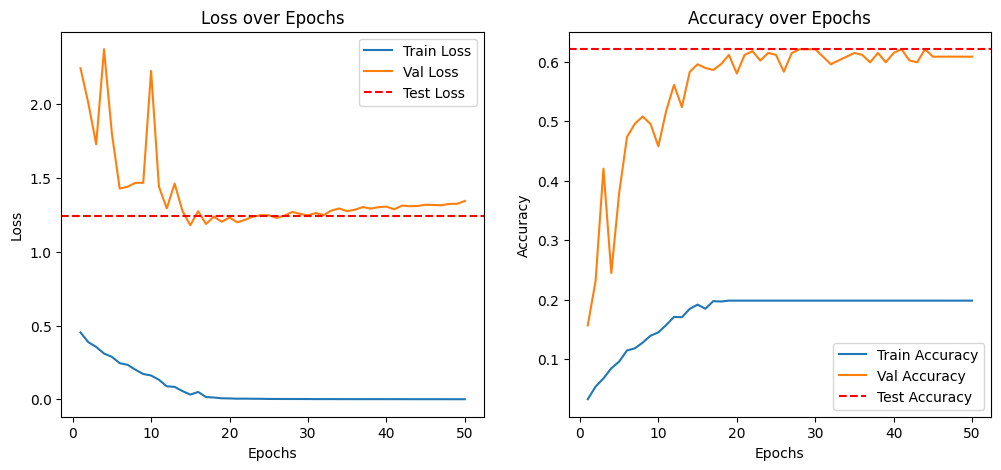

In [14]:
plot_metrics(train_loss, val_loss,test_loss, train_acc, val_acc, test_acc)

## Audio Data Process

In [ ]:
import os
import numpy as np
import torch
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
from torch import nn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Define paths
data_folder = "/root/data/Data/genres_original"

# Parameters
sample_rate = 22050  # Standard sample rate for audio
n_mfcc = 64  # Number of MFCC coefficients to extract
duration = 30  # Duration of audio to load (in seconds)
hop_length = 64  # Hop length for STFT
batch_size = 64
#num_epochs = 10

# Function to extract MFCCs using torchaudio
def extract_mfcc(file_path, n_mfcc=13, duration=30, sr=22050, hop_length=512):
    try:
        # Load audio file using torchaudio
        waveform, sample_rate = torchaudio.load(file_path)
        
        # Resample if necessary
        if sample_rate != sr:
            resampler = T.Resample(orig_freq=sample_rate, new_freq=sr)
            waveform = resampler(waveform)
        
        # Ensure the audio is mono
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        # Truncate or pad the audio to the desired duration
        target_length = sr * duration
        if waveform.shape[1] < target_length:
            padding = target_length - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, padding))
        else:
            waveform = waveform[:, :target_length]
        
        # Extract MFCCs using torchaudio
        mfcc_transform = T.MFCC(
            sample_rate=sr,
            n_mfcc=n_mfcc,
            melkwargs={"n_fft": 2048, "hop_length": hop_length, "n_mels": 64}
        )
        mfccs = mfcc_transform(waveform)
        
        # Take the mean across time to get a fixed-size vector
        mfccs = torch.mean(mfccs, dim=2).squeeze(0)
        
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        # Return a zero-filled array as a placeholder
        mfccs = torch.zeros(n_mfcc)
    
    return mfccs

class AudioDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(labels)  # Fit the label encoder

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        # Extract MFCCs using the updated function
        mfccs = extract_mfcc(file_path, n_mfcc=n_mfcc, duration=duration, sr=sample_rate, hop_length=hop_length)

        # If MFCCs are None (due to an error), return a zero-filled array
        if mfccs is None:
            mfccs = torch.zeros(n_mfcc)  # Placeholder for invalid data

        # Encode label as integer
        label_encoded = self.label_encoder.transform([label])[0]

        # Convert to PyTorch tensors
        mfccs_tensor = mfccs.clone().detach().float()  # Ensure it's a float tensor
        label_tensor = torch.tensor(label_encoded, dtype=torch.long)

        return mfccs_tensor, label_tensor

# Collect all audio files and their labels
file_paths = []
labels = []
for genre_folder in os.listdir(data_folder):
    genre_path = os.path.join(data_folder, genre_folder)
    if os.path.isdir(genre_path):
        for file_name in os.listdir(genre_path):
            file_path = os.path.join(genre_path, file_name)
            if file_path.endswith(".wav"):  # Ensure only WAV files are processed
                file_paths.append(file_path)
                labels.append(genre_folder)

# Encode labels as integers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(file_paths, labels_encoded, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Create datasets
train_dataset = AudioDataset(X_train, y_train)
val_dataset = AudioDataset(X_val, y_val)
test_dataset = AudioDataset(X_test, y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## RNN Model

In [10]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # Reset counter if loss improves
        else:
            self.counter += 1  # Increment counter if no improvement
        
        return self.counter >= self.patience  # Stop if patience is exceeded

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out




In [11]:
def train(model, experiment, hyper, optimizer, loss_fn=nn.CrossEntropyLoss()):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    early_stopping = EarlyStopping(patience=10)

    for epoch in range(hyper['epochs']):
        model.cuda()
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_accuracy = 0.0

        # Training 
        for mfccs, labels in train_loader:
            mfccs = mfccs.unsqueeze(1).cuda()  # Add sequence_length dimension
            labels = labels.cuda()

            # Forward pass
            output = model(mfccs)
            loss = loss_fn(output, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update running loss and accuracy
            running_loss = 0.99 * running_loss + 0.01 * loss.item()
            preds = torch.argmax(output, dim=1)
            running_accuracy = 0.99 * running_accuracy + 0.01 * accuracy_score(labels.cpu(), preds.cpu())

        # Store training loss and accuracy
        train_losses.append(running_loss)
        train_accuracies.append(running_accuracy)
        experiment.log_metric("train_loss", running_loss)
        experiment.log_metric("train_accuracy", running_accuracy)

        print(f"Epoch {epoch+1}/{hyper['epochs']}")
        print(f"Train Loss: {running_loss:.4f}, Train Accuracy: {running_accuracy:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        val_accuracy = 0.0
        with torch.no_grad():  
            for mfccs, labels in val_loader:
                mfccs = mfccs.unsqueeze(1).cuda() 
                labels = labels.cuda()

                output = model(mfccs)
                loss = loss_fn(output, labels)

                val_loss += loss.item()
                preds = torch.argmax(output, dim=1)
                val_accuracy += accuracy_score(labels.cpu(), preds.cpu())

        val_loss /= len(val_loader)
        val_accuracy /= len(val_loader)

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        experiment.log_metric("val_loss", val_loss)
        experiment.log_metric("val_accuracy", val_accuracy)

        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        
        if early_stopping(val_loss):
            print("Early stopping triggered!")
            break

    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    with torch.no_grad():
        for mfccs, labels in test_loader:
            # Reshape input to (batch_size, sequence_length=1, input_size=13)
            mfccs = mfccs.unsqueeze(1).cuda()  # Add sequence_length dimension
            labels = labels.cuda()

            # Forward pass
            output = model(mfccs)
            loss = loss_fn(output, labels)

            # Update test loss and accuracy
            test_loss += loss.item()
            preds = torch.argmax(output, dim=1)
            test_accuracy += accuracy_score(labels.cpu(), preds.cpu())

    # Average test loss and accuracy
    test_loss /= len(test_loader)
    test_accuracy /= len(test_loader)
    experiment.log_metric("test_loss", test_loss)
    experiment.log_metric("test_accuracy", test_accuracy)

    # Print test loss and accuracy
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies, test_loss, test_accuracy

In [12]:
experiment_cnn = comet_ml.start(
  api_key="dEZzsaQExxOoLg04pynb"
  "idvNw",
  project_name="Deep Learning Technologies",
  workspace="gibranfil"
)
experiment_cnn.set_name ("LSTM")


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/gibranfil/deep-learning-technologies/ffde32d9897541ec93a3012f2a1cd648



In [13]:
# Hyperparameters
input_size = n_mfcc  # Number of MFCC features
hidden_size = 512
num_layers = 4
num_classes = len(label_encoder.classes_)  # Number of unique genres


In [14]:
param_lstm_batch = {'learning_rate' : 0.001, 'epochs' : 50}
experiment_cnn.log_parameters (param_lstm_batch)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=param_lstm_batch['learning_rate'])

In [15]:
log_model(experiment_cnn, model=model, model_name="LSTM")
train_loss, val_loss, train_acc, val_acc, test_loss, test_acc= train (model, experiment_cnn,param_lstm_batch,optimizer) 

Epoch 1/50
Train Loss: 0.2132, Train Accuracy: 0.0173
Val Loss: 2.0975, Val Accuracy: 0.2305


KeyboardInterrupt: 

In [ ]:
experiment_cnn.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : LSTM
COMET INFO:     url                   : https://www.comet.com/gibranfil/deep-learning-technologies/78f72888fc9e47439e5ef06d5b530b8b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [43]           : (0.24178580939769745, 2.3013498783111572)
COMET INFO:     test_accuracy       : 0.5625
COMET INFO:     test_loss           : 1.639966607093811
COMET INFO:     train_accuracy [42] : (0.01515847662548341, 0.0860433457036931)
COMET INFO:     train_loss [42]     : (0.02667523718231103, 0.2125530001091514)
COMET INFO:     val_accuracy [42]   : (0.1640625, 0.57421875)
COMET INFO:     val_loss [42]       : (1.4886469841003418, 2.107616901397705

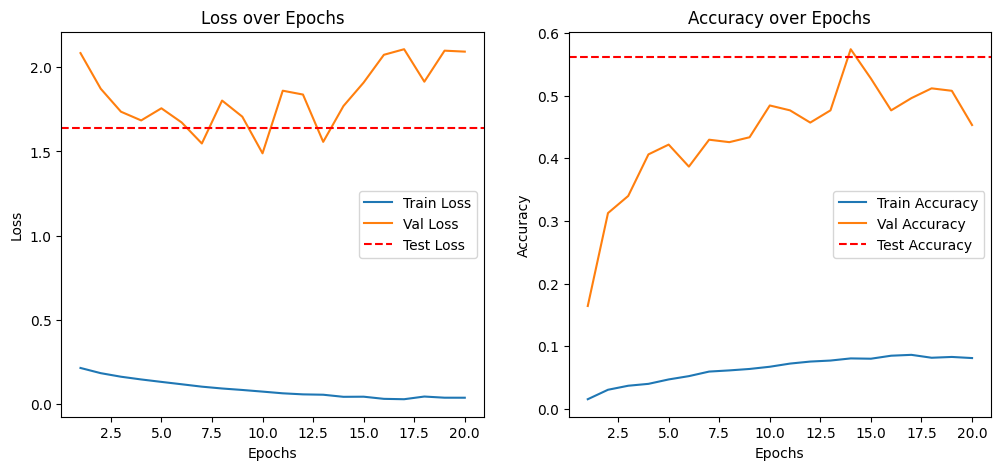

In [ ]:
plot_metrics(train_loss, val_loss,test_loss, train_acc, val_acc, test_acc)

## GAN Network

### Audio Load

### GAN Model

In [2]:
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, output_dim),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128,1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

### Train Function

In [13]:
import torch
import torch.nn as nn
#from sklearn.metrics import accuracy_score

def train_gan(generator, discriminator, experiment, hyper, optimizer_G, optimizer_D, loss_fn=nn.BCELoss()):
    train_losses_G = []
    train_losses_D = []
    val_losses_G = []
    val_losses_D = []
    early_stopping = EarlyStopping(patience=10)

    for epoch in range(hyper['epochs']):
        generator.cuda()
        discriminator.cuda()
        generator.train()  # Set generator to training mode
        discriminator.train()  # Set discriminator to training mode

        running_loss_G = 0.0
        running_loss_D = 0.0

        # Training loop
        for mfccs, _ in train_loader:  # Labels are not needed for GAN training
            mfccs = mfccs.unsqueeze(1).cuda()  # Add sequence_length dimension
            batch_size = mfccs.size(0)

            # Real data
            real_labels = torch.ones(batch_size, 1).cuda()
            # Fake data
            z = torch.randn(batch_size, hyper['latent_dim']).cuda()
            fake_mfccs = generator(z)
            fake_labels = torch.zeros(batch_size, 1).cuda()
            # Train Discriminator
            optimizer_D.zero_grad()
            real_loss = loss_fn(torch.squeeze(discriminator(mfccs),-1), real_labels)
            fake_loss = loss_fn(discriminator(fake_mfccs.detach()), fake_labels)
            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            g_loss = loss_fn(discriminator(fake_mfccs), real_labels)
            g_loss.backward()
            optimizer_G.step()

            # Update running losses
            running_loss_G = 0.99 * running_loss_G + 0.01 * g_loss.item()
            running_loss_D = 0.99 * running_loss_D + 0.01 * d_loss.item()

        # Store training losses
        train_losses_G.append(running_loss_G)
        train_losses_D.append(running_loss_D)
        experiment.log_metric("train_loss_G", running_loss_G)
        experiment.log_metric("train_loss_D", running_loss_D)

        # Print training losses
        print(f"Epoch {epoch+1}/{hyper['epochs']}")
        print(f"Generator Loss: {running_loss_G:.4f}, Discriminator Loss: {running_loss_D:.4f}")

        # Validation loop
        generator.eval()
        discriminator.eval()
        val_loss_G = 0.0
        val_loss_D = 0.0
        with torch.no_grad():
            for mfccs, _ in val_loader:
                mfccs = mfccs.unsqueeze(1).cuda()
                batch_size = mfccs.size(0)

                # Real data
                real_labels = torch.ones(batch_size, 1).cuda()
                # Fake data
                z = torch.randn(batch_size, hyper['latent_dim']).cuda()
                fake_mfccs = generator(z)
                fake_labels = torch.zeros(batch_size, 1).cuda()

                # Discriminator loss on real and fake data
                real_loss = loss_fn(torch.squeeze(discriminator(mfccs),-1), real_labels)
                fake_loss = loss_fn(discriminator(fake_mfccs), fake_labels)
                d_loss = real_loss + fake_loss

                # Generator loss
                g_loss = loss_fn(discriminator(fake_mfccs), real_labels)

                val_loss_G += g_loss.item()
                val_loss_D += d_loss.item()

        # Average validation losses
        val_loss_G /= len(val_loader)
        val_loss_D /= len(val_loader)

        # Store validation losses
        val_losses_G.append(val_loss_G)
        val_losses_D.append(val_loss_D)
        experiment.log_metric("val_loss_G", val_loss_G)
        experiment.log_metric("val_loss_D", val_loss_D)

        # Print validation losses
        print(f"Val Generator Loss: {val_loss_G:.4f}, Val Discriminator Loss: {val_loss_D:.4f}")

        # Early stopping
        if early_stopping(val_loss_G + val_loss_D):
            print("Early stopping triggered!")
            break

    # Testing loop (optional, can be done after training)
    generator.eval()
    discriminator.eval()
    test_loss_G = 0.0
    test_loss_D = 0.0
    with torch.no_grad():
        for mfccs, _ in test_loader:
            mfccs = mfccs.unsqueeze(1).cuda()
            batch_size = mfccs.size(0)

            # Real data
            real_labels = torch.ones(batch_size, 1).cuda()
            # Fake data
            z = torch.randn(batch_size, hyper['latent_dim']).cuda()
            fake_mfccs = generator(z)
            fake_labels = torch.zeros(batch_size, 1).cuda()

            # Discriminator loss on real and fake data
            real_loss = loss_fn(torch.squeeze(discriminator(mfccs),-1), real_labels)
            fake_loss = loss_fn(discriminator(fake_mfccs), fake_labels)
            d_loss = real_loss + fake_loss

            # Generator loss
            g_loss = loss_fn(discriminator(fake_mfccs), real_labels)

            test_loss_G += g_loss.item()
            test_loss_D += d_loss.item()

    # Average test losses
    test_loss_G /= len(test_loader)
    test_loss_D /= len(test_loader)
    experiment.log_metric("test_loss_G", test_loss_G)
    experiment.log_metric("test_loss_D", test_loss_D)

    # Print test losses
    print(f"Test Generator Loss: {test_loss_G:.4f}, Test Discriminator Loss: {test_loss_D:.4f}")

    return train_losses_G, train_losses_D, val_losses_G, val_losses_D, test_loss_G, test_loss_D

In [14]:
experiment_cnn = comet_ml.start(
  api_key="dEZzsaQExxOoLg04pynb"
  "idvNw",
  project_name="Deep Learning Technologies",
  workspace="gibranfil"
)
experiment_cnn.set_name ("GAN")


COMET INFO: An experiment with the same configuration options is already running and will be reused.


In [15]:
hyper = {
    'epochs': 100,
    'latent_dim': 100,
    'batch_size': 64
}

# Initialize models, optimizers, and data loaders
generator = Generator(latent_dim=hyper['latent_dim'], output_dim=13)  # Example output_dim for MFCCs
discriminator = Discriminator(input_dim=13)  # Example input_dim for MFCCs
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002)



In [16]:
train_loss_G, train_loss_D, val_loss_G, val_loss_D, test_loss_G, test_loss_D = train_gan(
    generator, discriminator, experiment_cnn, hyper, optimizer_G, optimizer_D
)

Epoch 1/100
Generator Loss: 0.0637, Discriminator Loss: 0.0854
Val Generator Loss: 0.6544, Val Discriminator Loss: 0.7340
Epoch 2/100
Generator Loss: 0.0622, Discriminator Loss: 0.0708
Val Generator Loss: 0.6460, Val Discriminator Loss: 0.7428
Epoch 3/100
Generator Loss: 0.0621, Discriminator Loss: 0.0710
Val Generator Loss: 0.6492, Val Discriminator Loss: 0.7392
Epoch 4/100
Generator Loss: 0.0632, Discriminator Loss: 0.0699
Val Generator Loss: 0.6679, Val Discriminator Loss: 0.7192
Epoch 5/100
Generator Loss: 0.0654, Discriminator Loss: 0.0677
Val Generator Loss: 0.6946, Val Discriminator Loss: 0.6917
Epoch 6/100
Generator Loss: 0.0679, Discriminator Loss: 0.0652
Val Generator Loss: 0.7160, Val Discriminator Loss: 0.6709
Epoch 7/100
Generator Loss: 0.0695, Discriminator Loss: 0.0637
Val Generator Loss: 0.7299, Val Discriminator Loss: 0.6580
Epoch 8/100
Generator Loss: 0.0711, Discriminator Loss: 0.0624
Val Generator Loss: 0.7517, Val Discriminator Loss: 0.6384
Epoch 9/100
Generator Lo

In [17]:
plot_metrics(train_loss_G, val_loss_G, gan=True)

NameError: name 'plot_metrics' is not defined

In [29]:
z = torch.randn(batch_size, 100).cuda()
fake_mfccs = generator(z).cpu()

In [30]:
fake_mfccs

tensor([[ 0.8302,  0.9786,  0.1772,  0.3380, -0.1607,  0.3236,  0.8231, -0.8447,
         -0.8411, -0.5713, -0.8555,  0.8457, -0.7358]],
       grad_fn=<ToCopyBackward0>)